In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [3]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())

In [3]:
df=pd.read_hdf("all_wind.h5")

In [4]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [5]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

In [6]:
def get_ts_visual_details():
    return(df[df.visual=="null"].timeStamp.unique(),df[df.visual=="grassSky"].timeStamp.unique())

In [262]:
def get_wbad_files(files):
    case_dict={}
    for file in files:
        df2 =  df[df.timeStamp == file]
        case=df2.trajectory__case.unique()
        case_dict[file]={}
        for c in case:
            runs=df2[df2.trajectory__case==c].trajectory__runNum.unique()
            for r in runs:
                arr=df2[(df2.trajectory__runNum==r)&(df2.trajectory__case==c)].trajectory__pOri_x.values
                if arr.shape[0]>0:
                    case_dict[file]["c_"+str(int(c))+"_"+"r_"+str(int(r))]=arr
    return case_dict


In [8]:
def get_Dtw_matrix(file_dict):
    ln =len(file_dict.keys())
    mat_=np.zeros((ln,ln))
    keys=[]
    vals=[]
    for k,v in  file_dict.items():
        keys.append(k)
        vals.append(v)
    for r in range(ln):
        for c in range(r+1,ln):
            mat_[r,c],_=fastdtw(vals[r],vals[c],dist=euclidean)
            mat_[c,r]=mat_[r,c]
    
    return(mat_,keys)

In [271]:
def visualize_matrix(mat,keys,folder_to_save,title="",
                     is_num=False,iterpolation="spline36",slice_mat=0):
    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(111)
    #visualize_matrix(vals,c,key)
    #print(mat)
    min_=mat.min()
    mat=((mat-min_)/(mat.max()-min_))*100
    mat_=mat[slice_mat:,slice_mat:]
    cax = ax.matshow(mat_,interpolation=iterpolation,vmin=0,vmax=100)
    fig.colorbar(cax)
    ticks = np.arange(0,mat_.shape[0],1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(keys[slice_mat:],fontsize=20,rotation=90)
    ax.set_yticklabels(keys[slice_mat:],fontsize=20)
    if is_num:
        for i in range(mat_.shape[0]):
            for j in range(mat_.shape[0]):
                c = mat_[j,i]
                ax.text(i, j, str(c)[:3], fontsize=22,va='center', ha='center')
    plt.text(0, -3,title,fontsize="xx-large")
    fig.savefig(folder_to_save+"/"+title+".jpeg",bbox_inches = 'tight')
    plt.close()

In [243]:
def get_windPressure(file):
    return(df[df.timeStamp==file].windPressure.unique()[0])

In [ ]:
def plot_matrix(times):

In [238]:
def get_run_indices(lst_nuls):
    get_nl_fl_trajectory={}
    for file in lst_nuls: #for each file
        df2 = df[df.timeStamp==file]
        case_s = df2.trajectory__case.unique()
        get_nl_fl_trajectory[file]=[]
        for case in case_s:
            df3=df2[df2.trajectory__case==case]
            if(df3.shape[0] >0):
                get_nl_fl_trajectory[file].append(
                    len(df3.trajectory__runNum.unique()))
    return(get_nl_fl_trajectory)

In [10]:
nuls,grassSky=get_ts_visual_details()

In [152]:
lst_nuls=['2018-03-30__14~13~06', '2018-01-17__12~12~40',
       '2018-01-17__12~32~54', '2018-03-28__15~56~32',
       '2018-03-28__15~49~36', '2018-03-30__14~33~21']

nuls_remaining=[]

for s in nuls:
    if s not in lst_nuls:
        nuls_remaining.append(s)


In [154]:
lst_grassSky=['2018-01-17__14~43~47','2018-01-17__14~38~15',
              '2018-01-24__20~54~18','2018-01-24__20~20~12',
              '2018-01-24__20~36~56','2018-01-17__19~54~53',
              '2018-01-17__20~13~09']

grassSky_remaining = []

for s in grassSky:
    if s not in lst_grassSky:
        grassSky_remaining.append(s)

In [164]:
#nuls_dict=get_wbad_files(lst_nuls)
nuls_remaining_dict=get_wbad_files(nuls_remaining)

In [165]:
nuls_vals=[vals for _,vals in nuls_dict.items()]
nuls_vals_remaining=[vals for _,vals in nuls_remaining_dict.items()]

In [166]:
#nuls_mat=pool.map(get_Dtw_matrix, nuls_vals)
nuls_mat_remaining=pool.map(get_Dtw_matrix, nuls_vals_remaining)

In [22]:
import pickle
filehandler = open("nuls_mat.dbt", 'wb+') 
pickle.dump(nuls_mat, filehandler)

In [138]:
grassSky_dat=get_wbad_files(lst_grassSky)
grassSky_vals=[vals for _,vals in grassSky_dat.items()] 

In [188]:
grassSky_dat_remaining=get_wbad_files(grassSky_remaining)
grassSky_vals_remaining=[vals for _,vals in grassSky_dat_remaining.items()] 

In [189]:
#grassSky_mat=pool.map(get_Dtw_matrix, grassSky_vals)
grassSky_mat_remaining=pool.map(get_Dtw_matrix, grassSky_vals_remaining)

In [ ]:
def get_runs_map(file):
    

In [30]:
get_nl_fl_trajectory

{'2018-03-30__14~13~06': [6, 5, 5, 5],
 '2018-01-17__12~12~40': [7, 6, 6, 6],
 '2018-01-17__12~32~54': [6, 5, 5, 5],
 '2018-03-28__15~56~32': [7, 6, 6, 6],
 '2018-03-28__15~49~36': [7, 6, 6, 6],
 '2018-03-30__14~33~21': [6, 5, 5, 5]}

In [31]:
get_grass_fl_trajectory={}
for file in lst_grassSky: #for each file
    df2 = df[df.timeStamp==file]
    case_s = df2.trajectory__case.unique()
    get_grass_fl_trajectory[file]=[]
    for case in case_s:
        df3=df2[df2.trajectory__case==case]
        if(df3.shape[0] >0):
            get_grass_fl_trajectory[file].append(len(df3.trajectory__runNum.unique()))

In [33]:
get_grass_fl_trajectory

{'2018-01-17__14~43~47': [7, 7, 6, 6],
 '2018-01-17__14~38~15': [6, 5, 5, 5],
 '2018-01-24__20~54~18': [7, 6, 6, 6],
 '2018-01-24__20~20~12': [7, 6, 6, 6],
 '2018-01-24__20~36~56': [8, 7, 7, 7],
 '2018-01-17__19~54~53': [9, 8, 8, 8],
 '2018-01-17__20~13~09': [9, 8, 8, 8]}

In [42]:
end_=np.cumsum(get_grass_fl_trajectory['2018-01-17__14~43~47'])

In [113]:
def get_score_matrix(mat,end_):
    end_=np.cumsum(end_)
    st=0
    c=np.zeros((4,4))
    for i in range(4):
        if i != 0:
            st = end_[i-1]
        r_s = st
        r_e = end_[i]
        for j in range(i,4):
            if j==0:
                c_s = st
                c_e = end_[j]
            else:
                c_s=end_[j-1]
                c_e=end_[j]
            if(i==j):
                mat_=mat[r_s:r_e,c_s:c_e]
                non_diag_mask = ~np.eye(mat_.shape[0],dtype=bool)
                c[i,j]=np.mean(mat_[non_diag_mask])
            else:
                c[i,j]=np.mean(mat[r_s:r_e,c_s:c_e])
                c[j,i]=c[i,j]
            #print(i,"-->",j,np.mean(mat[r_s:r_e,c_s:c_e]))
    #print(c)
    return(c)
            
            

In [114]:
grass_sky_score={}
for i,val in enumerate(grassSky_mat):
    grass_sky_score[lst_grassSky[i]]=get_score_matrix(val[0],get_grass_fl_trajectory[lst_grassSky[i]])

In [121]:
# nuls_score={}
# for i,val in enumerate(nuls_mat):
#     nuls_score[lst_nuls[i]]=get_score_matrix(val[0],get_nl_fl_trajectory[lst_nuls[i]])
grass_sky_score['2018-01-17__14~38~15'][1,1]

23.972441408549876

In [146]:
# grass_sky_score={}
# for i,val in enumerate(grassSky_mat):
#     grass_sky_score[lst_grassSky[i]]=get_score_matrix(val[0],get_grass_fl_trajectory[lst_grassSky[i]])

# keys= [str(i) for i in range(4) ]
# for title,mat_ in grass_sky_score.items():
#     visualize_matrix(mat_,keys,title)

In [183]:
nuls_mat.extend(nuls_mat_remaining)
lst_nuls.extend(nuls_remaining)
for i,val in enumerate(nuls_mat):
    wind=ge_windPressure(lst_nuls[i])
    file_to_store="heat_plots/null"
    title="W_"+wind+"_"+lst_nuls[i]
    visualize_matrix(val[0],val[1],file_to_store,title)

In [184]:
file_to_store="heat_plots/null_num"
for i,val in enumerate(nuls_mat):
    wind=ge_windPressure(lst_nuls[i])
    title="W_"+wind+"_"+lst_nuls[i]
    visualize_matrix(val[0],val[1],file_to_store,title,is_num=True,iterpolation='nearest')

In [185]:
filehandler = open("heat_plots/nuls_mat.dbt", 'wb+') 
pickle.dump({"mat":nuls_mat,"label":lst_nuls}, filehandler)

In [272]:
#grassSky_mat.extend(grassSky_mat_remaining)
#lst_grassSky.extend(grassSky_remaining)
for i,val in enumerate(grassSky_mat):
    ind=run_indices[lst_grassSky[i]][0]
    wind=ge_windPressure(lst_grassSky[i])
    file_to_store="heat_plots/grass_Sky_c_1_3"
    title="W_"+wind+"_"+lst_grassSky[i]
    visualize_matrix(val[0],val[1],file_to_store,title,slice_mat=ind)

In [269]:
ind

[7, 7, 6, 6]

In [187]:
filehandler = open("heat_plots/grassSky_mat.dbt", 'wb+') 
pickle.dump({"mat":grassSky_mat,"label":lst_grassSky}, filehandler)

In [191]:
case_dicts=get_wbad_files(['2018-01-24__20~36~56','2018-01-17__19~54~53'])

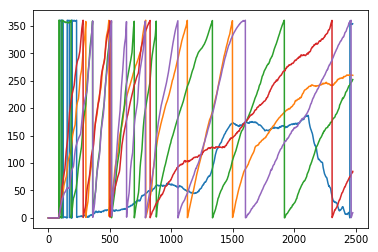

In [222]:
plt.plot(case_dicts['2018-01-24__20~36~56']['c_0_r_1']%360)
plt.plot(case_dicts['2018-01-24__20~36~56']['c_0_r_2']%360)
plt.plot(case_dicts['2018-01-24__20~36~56']['c_0_r_3']%360)
plt.plot(case_dicts['2018-01-24__20~36~56']['c_0_r_4']%360)
plt.plot(case_dicts['2018-01-24__20~36~56']['c_0_r_5']%360)

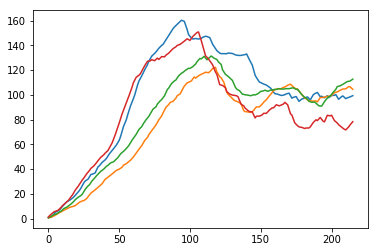

In [226]:
plt.plot((case_dicts['2018-01-24__20~36~56']['c_1_r_1']%360)[84:300])
plt.plot((case_dicts['2018-01-24__20~36~56']['c_1_r_2']%360)[84:300])
plt.plot((case_dicts['2018-01-24__20~36~56']['c_1_r_3']%360)[84:300])
plt.plot((case_dicts['2018-01-24__20~36~56']['c_1_r_4']%360)[84:300])

In [263]:
grassSky_dat=get_wbad_files(lst_grassSky)
grassSky_vals=[vals for _,vals in grassSky_dat.items()] 

In [273]:
grassSky_mat=pool.map(get_Dtw_matrix, grassSky_vals)

KeyboardInterrupt: 

In [231]:
# for i,val in enumerate(grassSky_mat):
#     wind=ge_windPressure(lst_grassSky[i])
#     file_to_store="heat_plots/grassSky_partial"
#     title="W_"+wind+"_"+lst_grassSky[i]
#     visualize_matrix(val[0],val[1],file_to_store,title)

In [239]:
#for key,val 
run_indices=get_run_indices(lst_grassSky)

In [241]:
run_indices[lst_grassSky[0]]

[7, 7, 6, 6]

In [264]:
for k,v in grassSky_dat.items():
    #upTo_count=np.cumsum(run_indices[k])
    wind=get_windPressure(k)
    fig=plt.figure(figsize=(12,20))
    title = "W_"+str(wind)+"_"+k+".jpeg"
    flag=-1
    count=0
    for k_,v_ in v.items():
        if flag-int(k_[2])!=0:
            
            count += 1
            ax=plt.subplot(4,1,count)
            ax.title.set_text("Case: "+str(count-1))
            flag=int(k_[2])
        plt.plot(v_,label=k_)
    #plt.text(0, -3,title,fontsize="xx-large")
    fig.savefig("heat_plots/time_series_grassSky/"+title+".jpeg",bbox_inches = 'tight')
    plt.close()

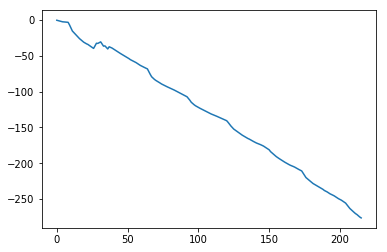

In [248]:
plt.plot(v_)